# GMM in PCA space of ensemble of reanalysis datasets

In [1]:
from importlib import reload
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as ctp
import seaborn as sns
from sklearn import mixture, decomposition

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../paper.mplstyle")

## Load data

In [2]:
datafile = "../data/reanalysis/monthly/ssta_merged_dataset_1.nc"
normalization = 'zscore'

ds = xr.open_dataset(datafile)

# Normalization
if normalization is not None:
    attributes = {}
    ds_norm = []
    for var in list(ds.data_vars):
        scaler = preproc.Normalizer(method=normalization)
        buff = scaler.fit_transform(ds[var])
        buff.attrs = {'normalizer': scaler}
        ds_norm.append(buff)

    ds = xr.merge(ds_norm) 

### EOF transformation

In [3]:
n_components = 2
sppca = eof.SpatioTemporalPCA(ds, n_components=n_components)
eofs = sppca.get_eofs()
pcs = sppca.get_principal_components()
pcs = pcs.assign_coords(member=('time', ds['member'].data))
print(f"Explained variance: {np.sum(sppca.explained_variance())}")

Explained variance: 0.48495523788460065


Plot EOF maps.

/tmp/ipykernel_35260/4242747044.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../output/plots/thesis/eof1-eof2.png", dpi=600, bbox_inches="tight")
/tmp/ipykernel_35260/4242747044.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../output/plots/thesis/eof1-eof2.png", dpi=600, bbox_inches="tight")
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


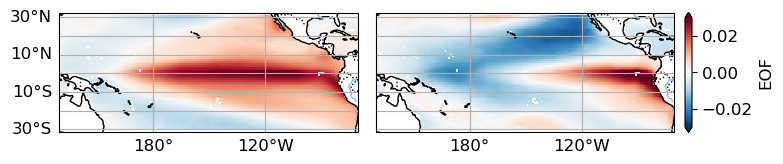

In [18]:
# EOF maps
vars = list(ds.data_vars)
fig = plt.figure(figsize=(7, 2*len(vars)))
proj = ctp.crs.PlateCarree(central_longitude=180)
axs = []
for i in range(sppca.n_components):
    comp = eofs.isel(eof=i)
    for j, var in enumerate(vars):
        ax = fig.add_subplot(len(vars), sppca.n_components, i+sppca.n_components*j+1, projection=proj)
        im = gpl.plot_map(comp[var], central_longitude=180, ax=ax,
                     bar='continuous', vmin=-.03, vmax=.03, add_bar=False)
        im['gl'].top_labels = False 
        if i > 0:
            im['gl'].left_labels = False 
        axs.append(ax)
        
cbar_ax = fig.add_axes([0.99, .2, 0.01, 0.6])
cb = fig.colorbar(im['im'], cax=cbar_ax, orientation='vertical', shrink=0.6, extend='both')
cb.set_label(label=rf"EOF")

gpl.enumerate_subplots(axs, pos_x=.01, pos_y=.85)

### Get ENSO events

In [5]:
reload(utenso)
month_range=[12, 2]
x_enso, x_events = utenso.select_enso_events(ds, month_range=month_range, threshold=0.5)
z_enso = xr.DataArray(
    data=sppca.transform(x_enso),
    coords={'time': x_enso['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
).assign_coords(member=('time', x_enso['member'].data))
z_events = xr.DataArray(
    data=sppca.transform(x_events),
    coords={'time': x_events['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
).assign_coords(member=('time', x_events['member'].data))

## Plot latent encoding

Text(0, 0.5, 'PC2')

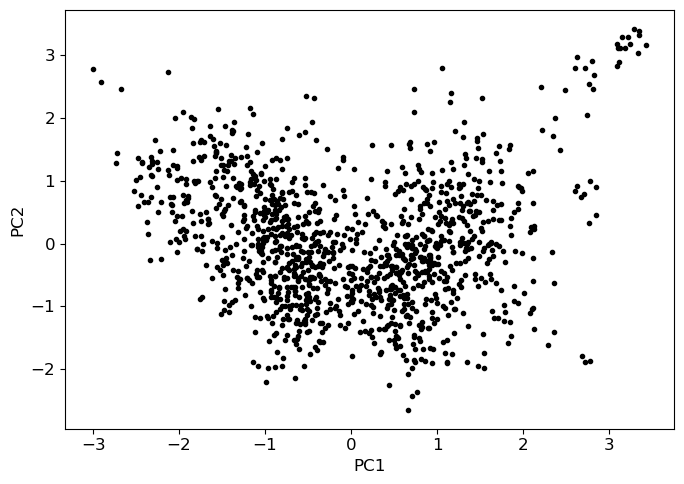

In [6]:
fig, ax = plt.subplots()
ax.plot(z_enso.isel(eof=0), z_enso.isel(eof=1), '.', color='k')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

Text(0, 0.5, 'PC2')

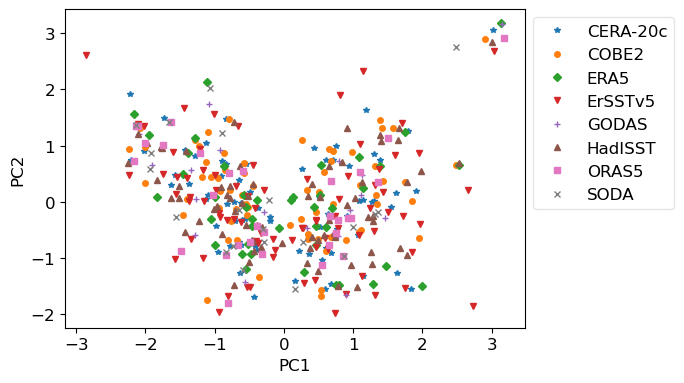

In [11]:
# Check differences between datasets
plparam = { 
    'COBE2':    dict(linestyle='', marker='o', markersize=4),
    'ErSSTv5':     dict(linestyle='', marker='v', markersize=4),
    'HadISST':  dict(linestyle='', marker='^', markersize=4), 
    'ORAS5':    dict(linestyle='', marker='s', markersize=4), 
    'GODAS':  dict(linestyle='', marker='+', markersize=4),
    'SODA':    dict(linestyle='', marker='x', markersize=4), 
    'ERA5':     dict(linestyle='', marker='D', markersize=4), 
    'CERA-20c':     dict(linestyle='', marker='*', markersize=4), 
}

fig, ax = plt.subplots(figsize=(7,4))
unique_members = np.unique(x_events['member'].data)
for i, membername in enumerate(unique_members):
    idx = np.where(x_events['member'].data == membername)[0]
    ax.plot(z_events.isel(eof=0)[idx], z_events.isel(eof=1)[idx], label=membername,
            **plparam[membername])

ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

## Thesis plot

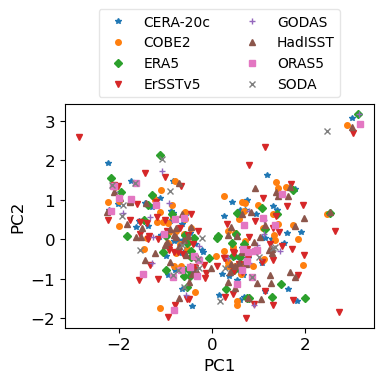

In [17]:
plparam = { 
    'COBE2':    dict(linestyle='', marker='o', markersize=4),
    'ErSSTv5':     dict(linestyle='', marker='v', markersize=4),
    'HadISST':  dict(linestyle='', marker='^', markersize=4), 
    'ORAS5':    dict(linestyle='', marker='s', markersize=4), 
    'GODAS':  dict(linestyle='', marker='+', markersize=4),
    'SODA':    dict(linestyle='', marker='x', markersize=4), 
    'ERA5':     dict(linestyle='', marker='D', markersize=4), 
    'CERA-20c':     dict(linestyle='', marker='*', markersize=4), 
}
fig, ax = plt.subplots(figsize=(4,4))

unique_members = np.unique(x_events['member'].data)
for i, membername in enumerate(unique_members):
    idx = np.where(x_events['member'].data == membername)[0]
    ax.plot(z_events.isel(eof=0)[idx], z_events.isel(eof=1)[idx], label=membername,
            **plparam[membername])

ax.legend(bbox_to_anchor=(0.5,1.), loc="lower center", fontsize='small', ncols=2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.savefig("../output/plots/thesis/pc1-pc2_events.png", dpi=600, bbox_inches="tight")


/tmp/ipykernel_35260/2776993424.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../output/plots/thesis/eof1-eof2.png", dpi=600, bbox_inches="tight")
/tmp/ipykernel_35260/2776993424.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../output/plots/thesis/eof1-eof2.png", dpi=600, bbox_inches="tight")
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


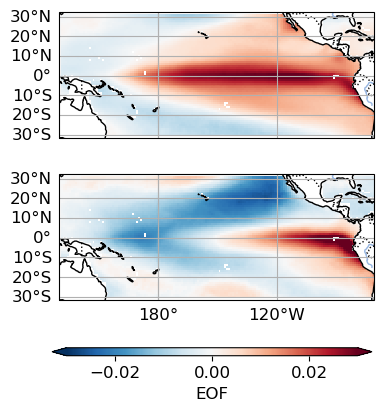

In [25]:
# EOF maps
vars = list(ds.data_vars)
fig = plt.figure(figsize=(4, 4))
proj = ctp.crs.PlateCarree(central_longitude=180)
axs = []
for i in range(sppca.n_components):
    comp = eofs.isel(eof=i)
    var = 'ssta'
    ax = fig.add_subplot(sppca.n_components, 1, i+1, projection=proj)
    im = gpl.plot_map(comp[var], central_longitude=180, ax=ax,
                 bar='continuous', vmin=-.03, vmax=.03, add_bar=False)
    im['gl'].top_labels = False 
    if i == 0:
        im['gl'].bottom_labels = False 
    axs.append(ax)
        
cbar_ax = fig.add_axes([0.15, .0, 0.8, 0.02])
cb = fig.colorbar(im['im'], cax=cbar_ax, orientation='horizontal', shrink=0.6, extend='both')
cb.set_label(label=rf"EOF")

#gpl.enumerate_subplots(axs, pos_x=.01, pos_y=.85)
plt.savefig("../output/plots/thesis/eof1-eof2.png", dpi=600, bbox_inches="tight")

## Gaussian mixture 

### Scan number of cluster

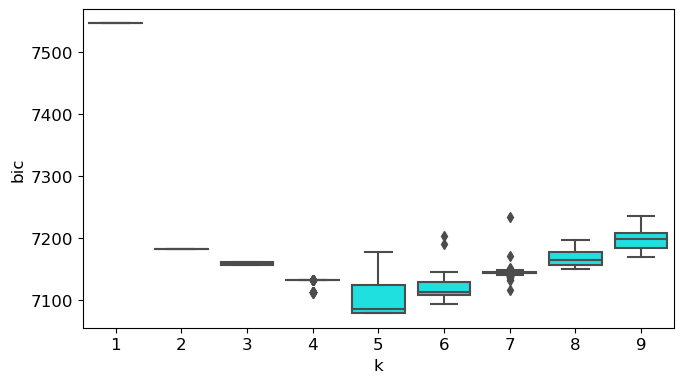

In [8]:
n_classes = np.arange(1, 10, 1)
n_runs = 100
result = []
for k in n_classes:
    for r in range(n_runs):
        gmm = mixture.GaussianMixture(n_components=k, 
                                      covariance_type='full', max_iter=100)#, init_params='random_from_data')
        gmm.fit(z_enso.data)
        result.append(
            {'k': k, 'bic': gmm.bic(z_enso.data), 'gmm': gmm}
        )
result = pd.DataFrame(result)

fig, ax = plt.subplots(figsize=(7,4))
ax = sns.boxplot(data=result, x='k', y='bic', ax=ax, color='cyan')

### Plot GMM

453


/tmp/ipykernel_48867/3388423209.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(f"../output/plots/pcgmm_representation_k{n_cluster}.png", dpi=300, bbox_inches='tight')


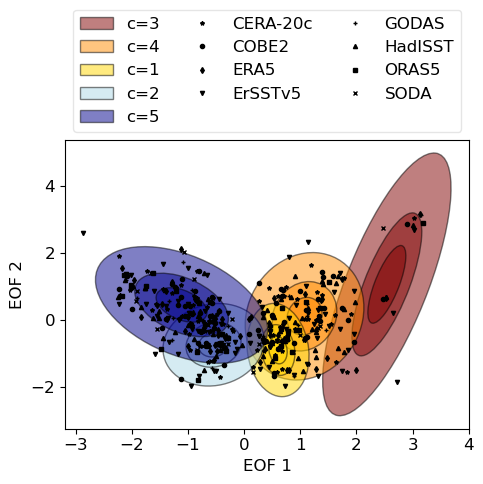

In [12]:
# Train GMM
n_cluster=5
n_rand = np.random.randint(0, 1000)
gmm_pca = mixture.GaussianMixture(n_components=n_cluster, 
                      covariance_type='full', max_iter=100,
                      random_state=n_rand, n_init=10)
gmm_pca.fit(z_enso.data)

# Plotting
plparam = { 
    'COBE2':    dict(linestyle='', marker='o', markersize=3),
    'ErSSTv5':  dict(linestyle='', marker='v', markersize=3),
    'HadISST':  dict(linestyle='', marker='^', markersize=3), 
    'ORAS5':    dict(linestyle='', marker='s', markersize=3), 
    'GODAS':    dict(linestyle='', marker='+', markersize=3),
    'SODA':     dict(linestyle='', marker='x', markersize=3), 
    'ERA5':     dict(linestyle='', marker='d', markersize=3), 
    'CERA-20c': dict(linestyle='', marker='*', markersize=3), 
}
fig, ax = plt.subplots(figsize=(5,5))

# Plot gmm means
gmm_order = np.argsort(gmm_pca.means_[:,0])[::-1]
gmclrs = ['maroon', 'darkorange', 'gold', 'lightblue', 'darkblue', 'black']

for i, k in enumerate(gmm_order):
    mean = gmm_pca.means_[k, :]
    if gmm_pca.covariance_type == "full":
        Sigma = gmm_pca.covariances_[k, :]
    elif gmm_pca.covariance_type == "diag":
        Sigma = np.diag(gmm_pca.covariances_[k, :])

    gmkwargs= dict(fill=False)
    if gmclrs is not None:
        gmkwargs['ec'] = 'k' #gmclrs[i] 
        gmkwargs['fc'] = gmclrs[i] 
        gmkwargs['fill'] = True
        gmkwargs['alpha'] = 0.5

    for p in [0.7, 0.3, 0.1]:
        if p==0.1:
            gmkwargs['label'] = f"c={k+1}"
        gpl.plot_2dgaussian(mean, Sigma,
                             ax=ax, p=p, **gmkwargs)

ax.set_xlabel("EOF 1")
ax.set_ylabel("EOF 2")

for i, member in enumerate(np.unique(ds['member'].data)):
    idx = np.where(x_events['member'].data == member)[0]
    ax.plot(z_events.isel(eof=0)[idx], z_events.isel(eof=1)[idx], color='k', label=member,
            **plparam[member])

ax.legend(bbox_to_anchor=(0., 1.0, 1., 0.1), loc="lower left", ncol=3, mode='expand')

### GMM means transformed to grid space

/tmp/ipykernel_74683/2765433605.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"../output/plots/pcgmm_gmmmeans_n{n_components}_k{n_cluster}.png", dpi=300, bbox_inches='tight')
/tmp/ipykernel_74683/2765433605.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"../output/plots/pcgmm_gmmmeans_n{n_components}_k{n_cluster}.png", dpi=300, bbox_inches='tight')
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


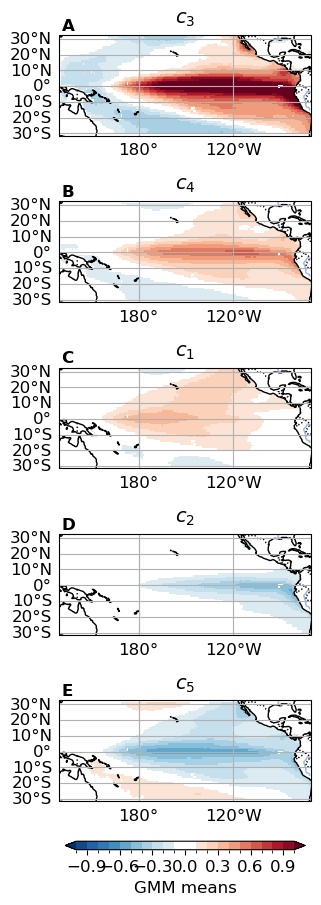

In [24]:
# Plot mean of Gaussian mixtures
plparam = {'ssta': dict(vmin=-1, vmax=1, step=0.1, cmap='RdBu_r', centercolor="#ffffff"),
           'ssha': dict(vmin=-.15, vmax=.15, step=0.025,cmap='RdGy_r', centercolor="#ffffff")}
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina',]

means = sppca.inverse_transform(gmm_pca.means_, newdim='mu')
means = ds['ssta'].attrs['normalizer'].inverse_transform(means)
# Unnormalize
if 'normalizer' in ds[list(ds.data_vars)[0]].attrs.keys():
    for var in list(ds.data_vars):
        means[var] = ds[var].attrs['normalizer'].inverse_transform(means[var])

vars = ds.data_vars
fig = plt.figure(figsize=(4, 1.7*len(gmm_order)))
proj = ctp.crs.PlateCarree(central_longitude=180)
axs = []
for i, k in enumerate(gmm_order):
    mu = means.sel(mu=k)
    for j, var in enumerate(vars):
        idx = len(vars)*i+j+1
        ax = fig.add_subplot(len(gmm_order), 1, idx, projection=proj)
        im = gpl.plot_map(mu[var], central_longitude=180, ax=ax, 
                          bar='discrete', add_bar=False, **plparam[var])
        im['gl'].top_labels = False 
        ax.set_title(rf"$c_{k+1}$", fontsize=14)
#        ax.set_title(labels[i], fontsize=12)
        axs.append(ax)

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -.01, 0.6, 0.01])
cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.7,
                    cax=cbar_ax, extend='both')
cbar.set_label(f"GMM means", size=12)

_ = gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=1.05, fontsize=12)


## Probabilistic weights

Get data from all reanalysis products and transform to PC space.

In [13]:
# Project data earlier than 1901 on GMM
project_earlier_on_gmm = False
if project_earlier_on_gmm:
    ds_all = xr.open_dataset("../data/reanalysis/monthly/ssta_all_data.nc")
    if normalization is not None:
        attributes = {}
        ds_norm = []
        for var in list(ds_all.data_vars):
            buff = scaler.fit_transform(ds_all[var])
            buff.attrs = {'normalizer': scaler}
            ds_norm.append(buff)

        ds_all = xr.merge(ds_norm) 

    month_range=[12, 2]
    x_enso_all, x_events_all = utenso.select_enso_events(ds_all, month_range=month_range, threshold=0.5)
    z_enso_all = xr.DataArray(
        data=sppca.transform(x_enso_all),
        coords={'time': x_enso_all['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
    ).assign_coords(member=('time', x_enso_all['member'].data))
    z_events_all = xr.DataArray(
        data=sppca.transform(x_events_all),
        coords={'time': x_events_all['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
    ).assign_coords(member=('time', x_events_all['member'].data))
    # Data before 1900
    idx_before19c = np.where(x_events_all['time'].data < np.datetime64('1900-01-01'))[0]
    z_enso_before19c = z_enso_all.isel(time=idx_before19c)
    idx_before19c = np.where(x_events_all['time'].data < np.datetime64('1900-01-01'))[0]
    z_events_before19c = z_events_all.isel(time=idx_before19c)

    # Plot added points
    fig, ax = plt.subplots()
    ax.plot(z_events.isel(eof=0), z_events.isel(eof=1), 'o', color='k')
    ax.plot(z_events_before19c.isel(eof=0), z_events_before19c.isel(eof=1), 'o', color='r')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
else:
    ds_all = ds
    z_events_all = z_events
    z_enso_all = z_enso

In [14]:
# Event weights
p_c_given_x = utenso.posterior_weights(
    z_events_all.data, means=gmm_pca.means_, covariances=gmm_pca.covariances_,
    prior_weights=gmm_pca.weights_
)
# convert to xarray
p_c_given_x_da = xr.DataArray(data=p_c_given_x, dims=['time', 'classes'], 
                              coords={ 
                                'time': z_events_all['time'].data,
                                'member': ('time', z_events_all['member'].data),
                                'classes': np.arange(p_c_given_x.shape[1]) + 1
                              })

# Mean posterior weights
timepoints = np.unique(p_c_given_x_da['time'].data)
p_c_given_x_mean = []
p_c_given_x_std = []
for t in timepoints:
    weight = p_c_given_x_da.sel(time=t)
    if len(weight.shape) > 1:
        p_c_given_x_mean.append(weight.mean(dim='time').data)
        p_c_given_x_std.append(weight.std(dim='time').data)
    else:
        p_c_given_x_mean.append(weight.data)
        p_c_given_x_std.append(np.zeros(shape=weight.shape))

p_c_given_x_mean = xr.DataArray(data=p_c_given_x_mean, coords={'time':timepoints, 'classes':p_c_given_x_da['classes']})        
p_c_given_x_std = xr.DataArray(data=p_c_given_x_std, coords={'time':timepoints, 'classes':p_c_given_x_da['classes']})        

array([<Axes: ylabel='$p(c_3|z)$'>, <Axes: ylabel='$p(c_4|z)$'>,
       <Axes: ylabel='$p(c_1|z)$'>, <Axes: ylabel='$p(c_2|z)$'>,
       <Axes: ylabel='$p(c_5|z)$'>], dtype=object)

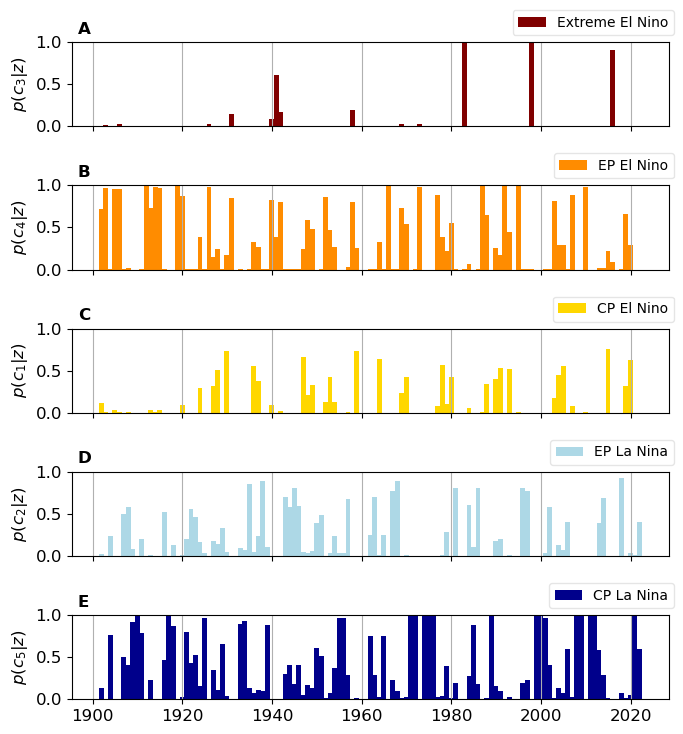

In [15]:
#  Plot posterior weights
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina', "rest"]
n_samples, n_classes = p_c_given_x.shape
fig, axs = plt.subplots(n_classes, 1, figsize=(7, 1.5*n_classes), sharex='col', sharey='row')

for i, k in enumerate(gmm_order):
    axs[i].bar(p_c_given_x_mean['time'].data, height=p_c_given_x_mean.sel(classes=k+1),
                 width=4e2, color=gmclrs[i], label=labels[i])
    axs[i].grid(axis='x')
    axs[i].set_ylabel(rf'$p(c_{k+1}|z)$')
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0, .5, 1])
    axs[i].legend(bbox_to_anchor=(.72, 1.0, 0.3, 0.1), loc="lower right", fontsize=10)

gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=1.1, fontsize=12)


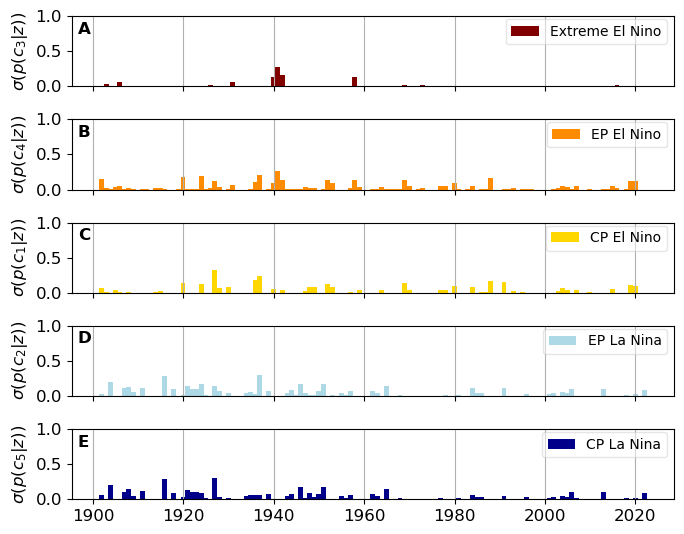

In [14]:
# Std of weights between datasets
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina',]
fig, axs = plt.subplots(n_classes, 1, figsize=(7, 1.1*n_classes), sharex='col', sharey='row')

for i, k in enumerate(gmm_order):
    axs[i].bar(p_c_given_x_std['time'].data, height=p_c_given_x_std.sel(classes=k+1),
                 width=4e2, color=gmclrs[i], label=rf"{labels[i]}")
    axs[i].grid(axis='x')
    axs[i].set_ylabel(rf'$\sigma ( p(c_{k+1}|z))$')
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0, .5, 1])
    axs[i].legend(bbox_to_anchor=(.7, .5, 0.3, 0.1), loc="lower right", fontsize=10)

_ = gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=.75, fontsize=12)

Compute monthly weights

In [15]:
# Monthly weights
p_c_given_x_month = utenso.posterior_weights(
    z_enso_all.data, means=gmm_pca.means_, covariances=gmm_pca.covariances_,
    prior_weights=gmm_pca.weights_
)
# convert to xarray
p_c_given_x_month = xr.DataArray(data=p_c_given_x_month, dims=['time', 'classes'], 
                              coords={ 
                                'time': z_enso_all['time'].data,
                                'member': ('time', z_enso_all['member'].data),
                                'classes': np.arange(p_c_given_x_month.shape[1]) + 1
                              })

# Mean posterior weights
timepoints = np.unique(p_c_given_x_month['time'].data)
weight_month_mean = []
weight_month_std = []
for t in timepoints:
    weight = p_c_given_x_month.sel(time=t)
    if len(weight.shape) > 1:
        weight_month_mean.append(weight.mean(dim='time').data)
        weight_month_std.append(weight.std(dim='time').data)
    else:
        weight_month_mean.append(weight.data)
        weight_month_std.append(np.zeros(shape=weight.shape))

weight_month_mean = xr.DataArray(data=weight_month_mean, coords={'time':timepoints, 'classes':p_c_given_x_month['classes']})        
weight_month_std = xr.DataArray(data=weight_month_std, coords={'time':timepoints, 'classes':p_c_given_x_month['classes']})        

In [16]:
# Save probability weights
if False:
    p_c_given_x_mean.attrs['gmm_sort'] = gmm_order
    p_c_given_x_mean.name = 'p_c_given_x'
    p_c_given_x_mean.to_netcdf(f"../output/pcgmm/pcgmm_n{n_components}_k{n_cluster}_weights_events_mean_sst.nc")
if False:
    weight_month_mean.attrs['gmm_sort'] = gmm_order
    weight_month_mean.name = 'p_c_given_x'
    weight_month_mean.to_netcdf(f"../output/pcgmm/pcgmm_n{n_components}_k{n_cluster}_weights_mon_mean_sst.nc")

## Weighted composites over all products

In [17]:
normalizer = ds['ssta'].attrs['normalizer']
da4comp = normalizer.inverse_transform(ds_all['ssta'])

for i, member in enumerate(np.unique(p_c_given_x_month['member'])):
    idx_member = np.where(p_c_given_x_month['member'].data == member)[0]
    weights = p_c_given_x_month.isel(time=idx_member)
    da_member = da4comp.isel(time=np.where(da4comp['member'].data == member)[0])
    da_member = da_member.sel(time=weights['time'].data)

    # Weighted mean
    weighted_mean_member = []
    for j, k in enumerate(weights['classes'].data):
        weight_class = weights.sel(classes=k)
        da_member_weighted = da_member.weighted(weight_class)
        weighted_mean_member.append(da_member_weighted.mean(dim='time'))
    weighted_mean_member = xr.concat(weighted_mean_member,
                                     dim=pd.Index(weights['classes'].data, name='classes'))
    weighted_mean = weighted_mean_member if i == 0 else (weighted_mean + weighted_mean_member)/2

/tmp/ipykernel_74683/2071710706.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"../output/plots/pcgmm_means_weighted_k{n_cluster}.png", dpi=300, bbox_inches='tight')
/tmp/ipykernel_74683/2071710706.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"../output/plots/pcgmm_means_weighted_k{n_cluster}.png", dpi=300, bbox_inches='tight')
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


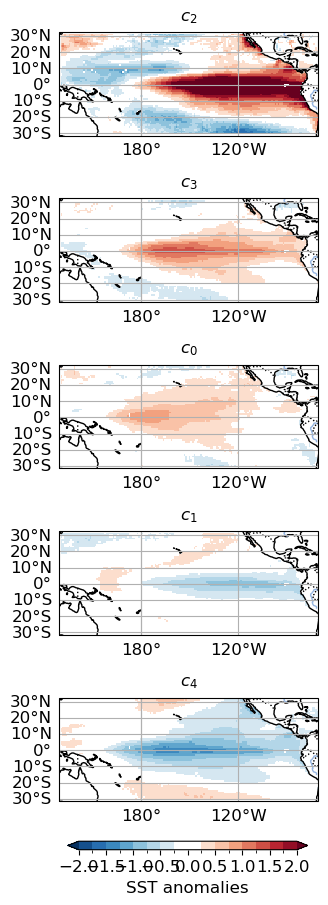

In [19]:
# Plot mean of Gaussian mixtures
plparam = dict(vmin=-2, vmax=2, step=0.25, cmap='RdBu_r', centercolor="#ffffff")
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina']

fig = plt.figure(figsize=(4*len(vars), 1.7*len(gmm_order)))
proj = ctp.crs.PlateCarree(central_longitude=180)
for i, k in enumerate(gmm_order):
    mu = weighted_mean.sel(classes=k+1)

    ax = fig.add_subplot(len(gmm_order), len(vars), i+1, projection=proj)
    im = gpl.plot_map(mu, central_longitude=180, ax=ax, 
                      bar='discrete', add_bar=False, **plparam)
    im['gl'].top_labels = False 
    ax.set_title(rf"$c_{k}$", fontsize=12)

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -.01, 0.6, 0.01])
cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.7,
                    cax=cbar_ax, extend='both')
cbar.set_label(f"SST anomalies", size=12)

if False:
    weighted_mean.to_netcdf(f"../output/pcgmm/pcgmm_n{n_components}_k{n_cluster}_weightedmean_sst.nc")
    plt.savefig(f"../output/plots/pcgmm_means_weighted_k{n_cluster}.png", dpi=300, bbox_inches='tight')